# Segmentez des clients d'un site e-commerce - *Notebook exploration*

## Mission

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. 

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiqr.

 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.

## Analyse exploratoire

### 1 - Découverte du jeu de données

Les données sont issues de la base de données d'Olist, obtenues via un script sql (voir script en pièce jointe).

In [4]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import timeit

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


In [5]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_5/data_projet/source/data_olist.csv", sep=',', low_memory=False)
data.head()

,customer_unique_id,latitude,longitude,nb_jours_anciennete,recence,frequence,montant,nb_jours_entre_chaque_commande,score_moyen,nb_notes
0,8d50f5eadf50201ccdcedfb9e2ac8455,-23.606033,-46.637242,519,57,17,729.62,30.573540,4.764706,17.0
1,3e43e6105506432c953e165fb2acf44c,-24.000695,-46.394515,393,231,9,1000.85,28.138743,2.777778,9.0
2,1b6c7548a2a1f9037c1fd3ddfed95f33,-18.946711,-49.451508,338,245,7,809.21,37.559075,5.000000,7.0
3,6469f99c1f9dfae7733b25662e7f1782,-23.948291,-46.325421,393,111,7,664.20,43.742868,5.000000,7.0
4,ca77025e7201e3b30c44b472ff346268,-8.121023,-34.896307,373,138,7,806.61,31.100443,5.000000,7.0


Les features sont :
- customer_unique_id
- latitude
- longitude
- nb_jours_anciennete (nombre de jours depuis la 1ere commande livrée)
- recence (nombre de jours depuis la dernière commande livrée)
- frequence (nombre total de commandes livrées)
- montant (cumulative_amount_orders - montant cumulé des commandes livrées)
- nb_jours_entre_chaque_commande (days_since_first_order divisé par total_orders = nombre de jours moyen entre 2 commandes livrées)
- score_moyen (score moyen)
- nb_notes (nombre total de reviews)

In [7]:
data.shape

(96096, 10)

In [8]:
data.describe()

,latitude,longitude,nb_jours_anciennete,recence,frequence,montant,nb_jours_entre_chaque_commande,score_moyen,nb_notes
count,95828.000000,95828.000000,96096.000000,96096.000000,96096.000000,95420.000000,96096.000000,95380.000000,95380.000000
mean,-21.116118,-46.115248,290.458552,287.735691,1.034809,142.440198,269.908472,4.084989,1.040302
std,5.728565,4.103342,153.903666,153.414676,0.214384,217.656355,154.774479,1.341571,0.254940
min,-33.683447,-72.456263,0.000000,0.000000,1.000000,0.850000,0.000000,1.000000,1.000000
25%,-23.577457,-48.051792,166.000000,163.000000,1.000000,47.900000,143.756704,4.000000,1.000000
50%,-22.898404,-46.612833,272.000000,268.000000,1.000000,89.900000,245.729340,5.000000,1.000000
75%,-20.023054,-43.470899,400.000000,397.000000,1.000000,155.000000,373.382616,5.000000,1.000000
max,45.065933,13.820214,772.000000,772.000000,17.000000,13440.000000,772.718565,5.000000,17.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              96096 non-null  object 
 1   latitude                        95828 non-null  float64
 2   longitude                       95828 non-null  float64
 3   nb_jours_anciennete             96096 non-null  int64  
 4   recence                         96096 non-null  int64  
 5   frequence                       96096 non-null  int64  
 6   montant                         95420 non-null  float64
 7   nb_jours_entre_chaque_commande  96096 non-null  float64
 8   score_moyen                     95380 non-null  float64
 9   nb_notes                        95380 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 7.3+ MB


In [10]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


customer_unique_id                0.00
nb_jours_anciennete               0.00
recence                           0.00
frequence                         0.00
nb_jours_entre_chaque_commande    0.00
latitude                          0.28
longitude                         0.28
montant                           0.70
score_moyen                       0.75
nb_notes                          0.75
dtype: float64

Certains clients n'ont pas fait de review. Ce sont les valeurs manquantes.

Certains clients ne sont pas localisés par la latitude et la longitude.

**Remplaçons les NaN par 0 pour le nombre de notes**

In [13]:
# Remplacer les valeurs manquantes par 0
data['nb_notes'] = data['nb_notes'].fillna(0)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              96096 non-null  object 
 1   latitude                        95828 non-null  float64
 2   longitude                       95828 non-null  float64
 3   nb_jours_anciennete             96096 non-null  int64  
 4   recence                         96096 non-null  int64  
 5   frequence                       96096 non-null  int64  
 6   montant                         95420 non-null  float64
 7   nb_jours_entre_chaque_commande  96096 non-null  float64
 8   score_moyen                     95380 non-null  float64
 9   nb_notes                        96096 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 7.3+ MB


**Regardons les doublons :**

In [16]:
data.nunique()

customer_unique_id                96096
latitude                          14798
longitude                         14791
nb_jours_anciennete                 623
recence                             630
frequence                             9
montant                            8391
nb_jours_entre_chaque_commande    95883
score_moyen                          33
nb_notes                             10
dtype: int64

Il n'y a pas de doublons sur le customer_id.

**Nombre de clients avec plus de 1 commande (fréquence > 1) :**

In [19]:
mask = data['frequence'] > 1
print("nombre de clients avec plus de 1 commande:", data.loc[mask].shape[0])

nombre de clients avec plus de 1 commande: 2997


### 2 - Analyse

#### 2.1 - Cartographie des clients par montant dépensé

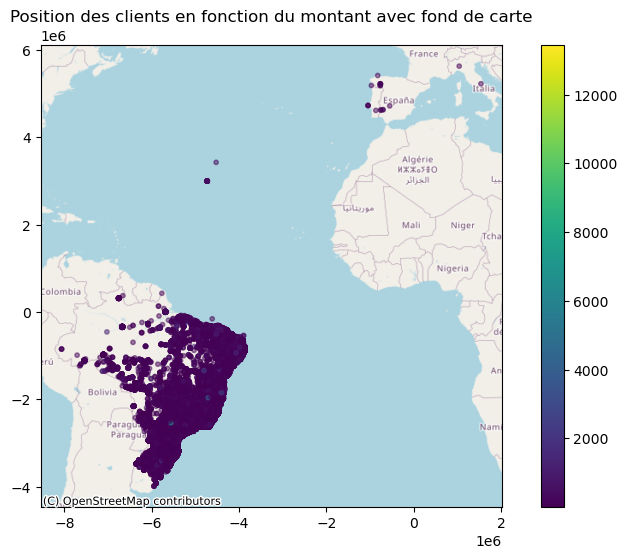

In [21]:
# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs="EPSG:4326"
)

# Convertir vos données en GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs="EPSG:4326"
)

# Reprojeter en Web Mercator (nécessaire pour les fonds de carte)
gdf = gdf.to_crs(epsg=3857)

# Définir l'étendue pour couvrir le monde entier
world_extent = [
    -20037508.34,  # Longitude minimale (en mètres, Web Mercator)
    -20037508.34,  # Latitude minimale
    20037508.34,   # Longitude maximale
    20037508.34    # Latitude maximale
]

# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(10, 6),
    alpha=0.5,
    markersize=10                    # Taille des points
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap
plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

**Zoom sur le Brésil**

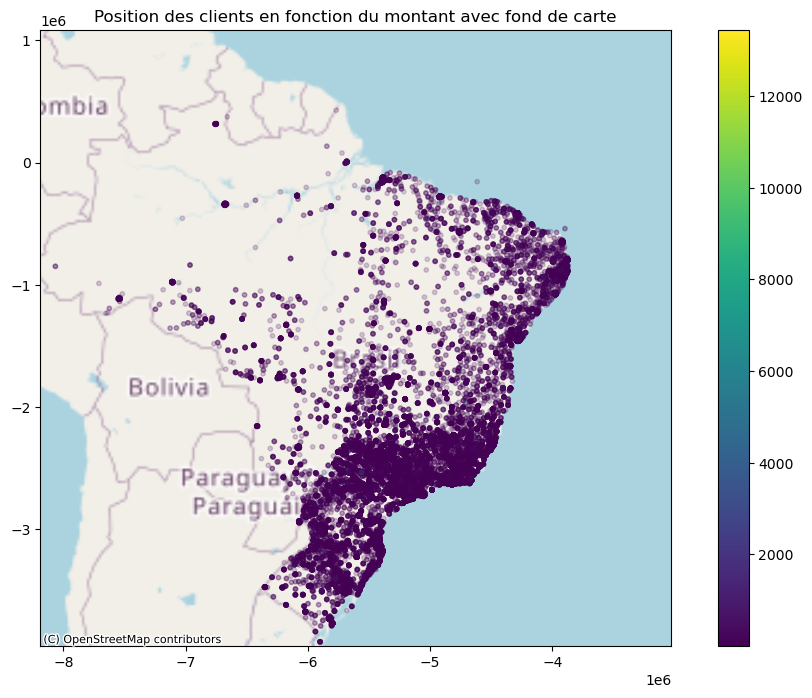

In [23]:
# Limites du Brésil en Web Mercator (approximation)
brazil_extent = [
    -8189898,  # Longitude minimale (en mètres)
    -3954361,  # Latitude minimale
    -3028275,  # Longitude maximale
    1084411    # Latitude maximale
]

# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(12, 8),
    alpha=0.2,
    markersize=10                    # Taille des points
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap

# Ajuster les limites pour zoomer sur le Brésil
ax.set_xlim(brazil_extent[0], brazil_extent[2])
ax.set_ylim(brazil_extent[1], brazil_extent[3])

plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

**Zoom sur le Brésil en réduisant l'échelle des montants**

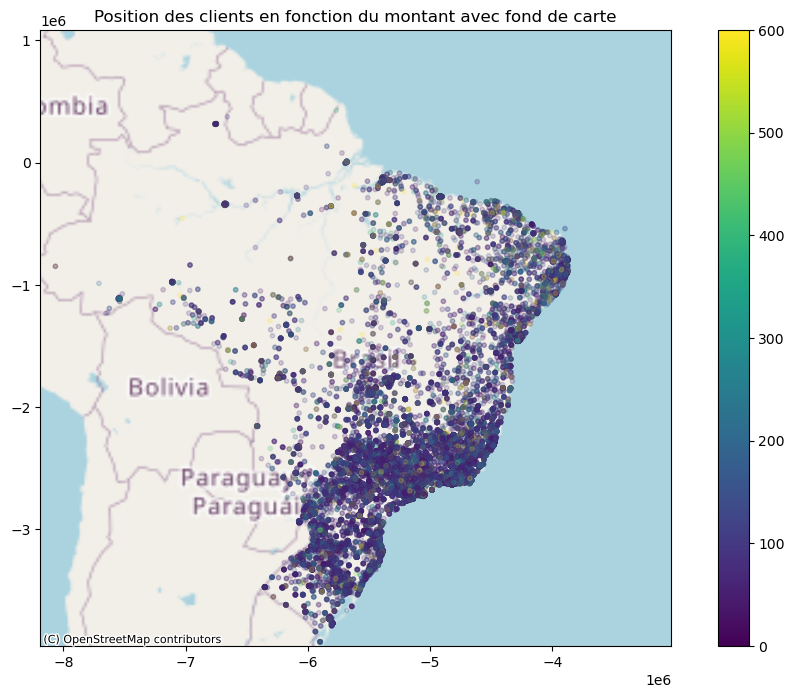

In [25]:
# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(12, 8),
    alpha=0.2,
    markersize=10,                   # Taille des points
    vmin=0,                          # Limite minimale de l'échelle des couleurs
    vmax=600                        # Limite maximale de l'échelle des couleurs
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap

# Ajuster les limites pour zoomer sur le Brésil
ax.set_xlim(brazil_extent[0], brazil_extent[2])
ax.set_ylim(brazil_extent[1], brazil_extent[3])

plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

#### 2.2 - Distribution des variables

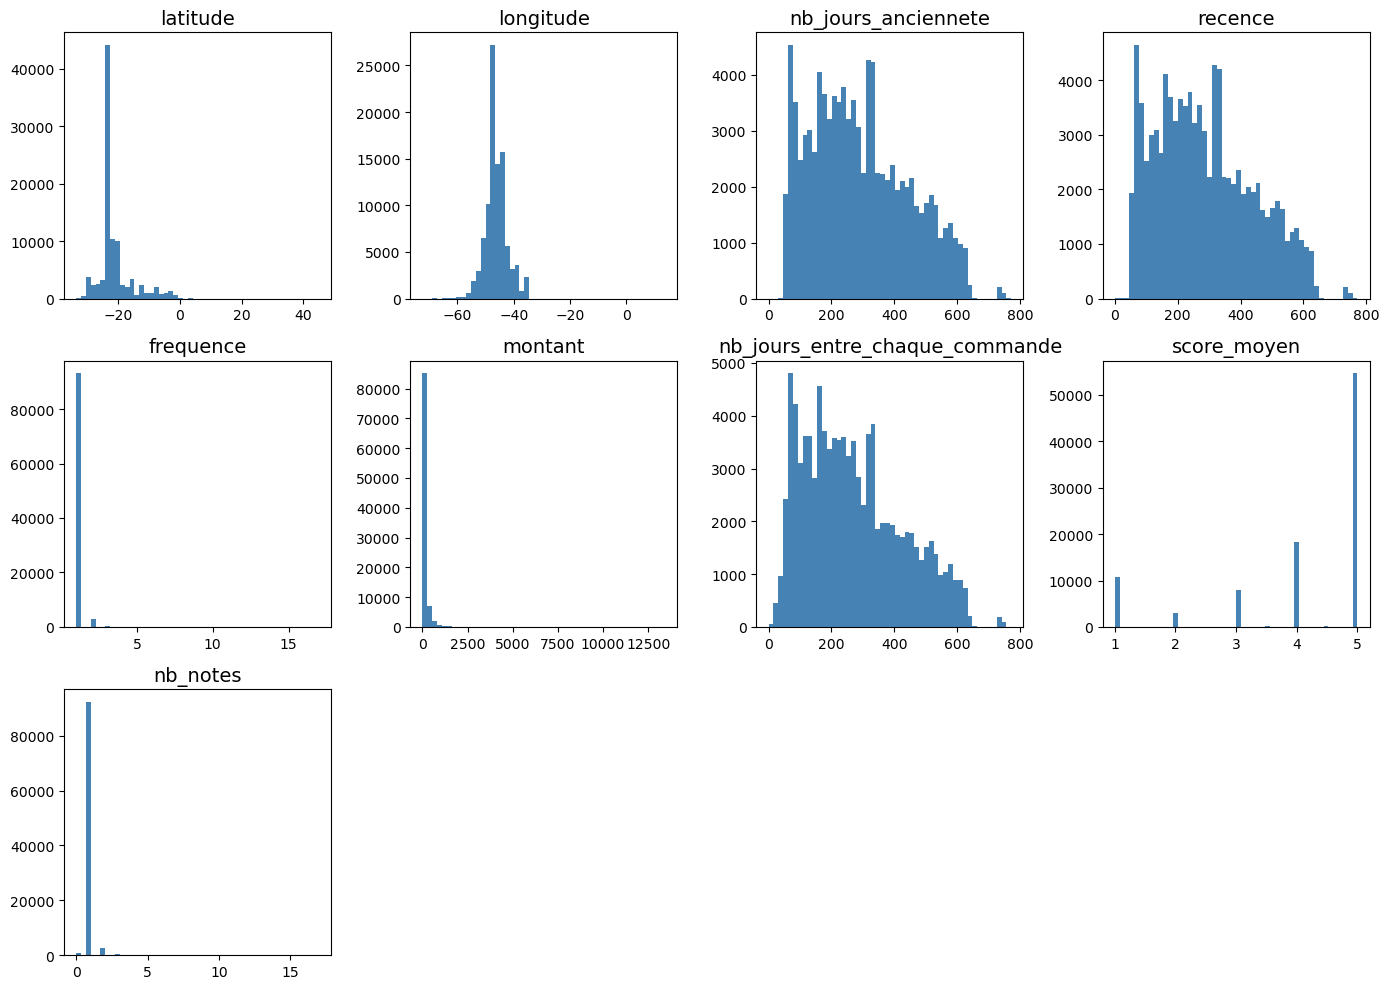

In [27]:
df = data.drop('customer_unique_id', axis=1, inplace=False)

# Créer des histogrammes pour chaque colonne
fig = plt.figure(figsize=(14, 10))
for feat_idx in range(df.shape[1]):  # Pour chaque colonne
    ax = fig.add_subplot(3, 4, feat_idx + 1)  # Ajouter à la grille
    h = ax.hist(df.iloc[:, feat_idx], bins=50, color="steelblue", edgecolor="none")
    ax.set_title(df.columns[feat_idx], fontsize=14)

plt.tight_layout()
plt.show()

Les distribution sont asymétriques.

**Remplaçons les NaN de la feature "socre_moyen" par la médiane**

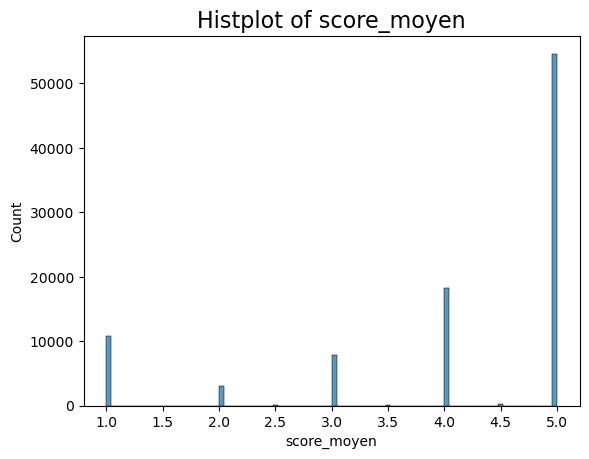

In [30]:
sns.histplot(data=df, x='score_moyen')
plt.title('Histplot of score_moyen', fontsize=16)
plt.show()

In [31]:
df['score_moyen'] = df['score_moyen'].fillna(df['score_moyen'].median())

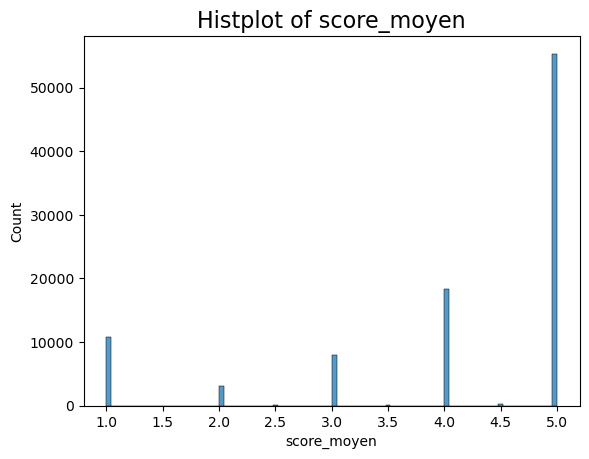

In [32]:
sns.histplot(data=df, x='score_moyen')
plt.title('Histplot of score_moyen', fontsize=16)
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        95828 non-null  float64
 1   longitude                       95828 non-null  float64
 2   nb_jours_anciennete             96096 non-null  int64  
 3   recence                         96096 non-null  int64  
 4   frequence                       96096 non-null  int64  
 5   montant                         95420 non-null  float64
 6   nb_jours_entre_chaque_commande  96096 non-null  float64
 7   score_moyen                     96096 non-null  float64
 8   nb_notes                        96096 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 6.6 MB


**Zoom de la distribution de la frequence**

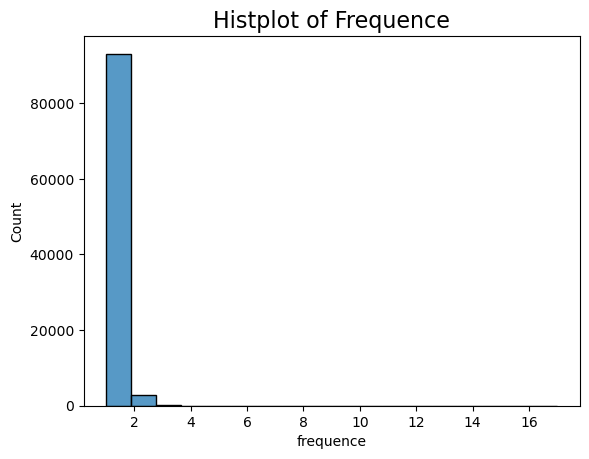

In [35]:
sns.histplot(data=df, x='frequence')
plt.title('Histplot of Frequence', fontsize=16)
plt.show()

Et sans les valeurs au-dessus de 10 :

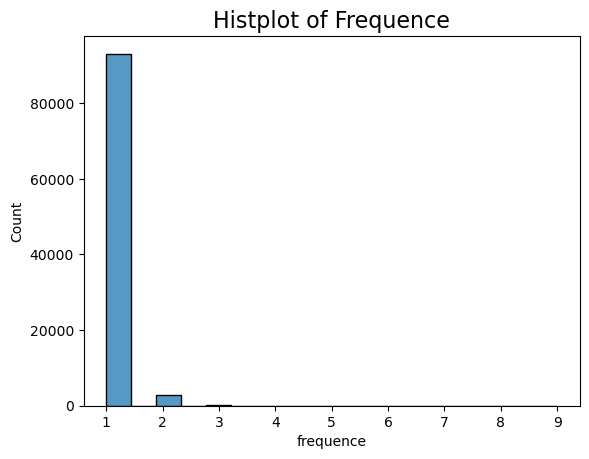

In [37]:
mask = df['frequence'] < 10
sns.histplot(data=df.loc[mask], x='frequence')
plt.title('Histplot of Frequence', fontsize=16)
plt.show()

La distribution est asymétrique. La plupart des clients ont réalisé une seule commande.

**Zoom de la distribution de feature montant**

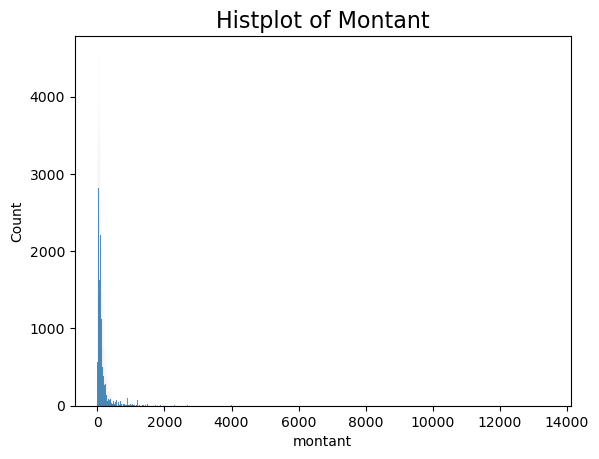

In [40]:
sns.histplot(data=df, x='montant')
plt.title('Histplot of Montant', fontsize=16)
plt.show()

Et sans les clients ayant dépensé plus de 2000 :

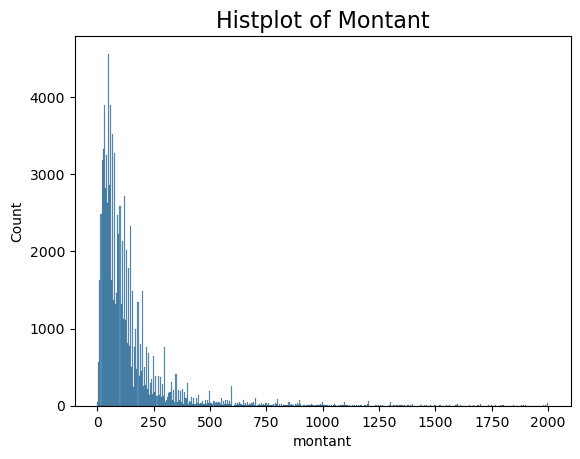

In [42]:
mask = df['montant'] < 2000
sns.histplot(data=df.loc[mask], x='montant')
plt.title('Histplot of Montant', fontsize=16)
plt.show()

La distribution est asymétrique

#### 2.3 - Analyse multivariée

**Matrice des corrélations:**

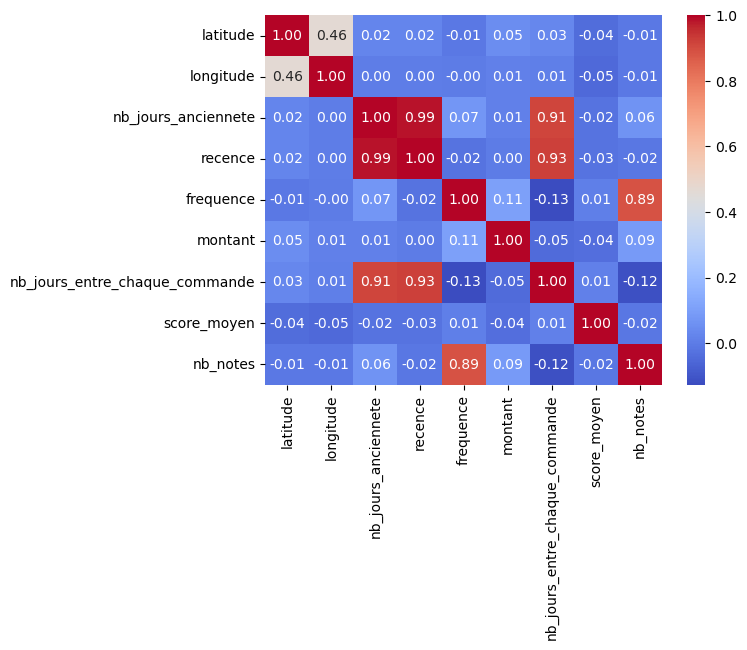

In [45]:
correlation_matrix = df.corr()

#plt.figure(figsize=(, 6))

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Afficher la heatmap
plt.show()

Observations :
- Il y a une corrélation très forte entre l'ancienneté et le nombre de la dernière commande (0.99). C'est normal car la plupart des clients ont réalisé une seule commande, donc la date de 1ère commande et la date de dernière commande se confonde. **La variable "nb_jours_ancienneté" ne sera donc pas utile pour le clustering.**
- Les corrélations entre "nb_jours_entre_chaque_commande" et "nb_jours_ancienneté" (et "récence") est également très forte (0.91 et 0.92). Normal à cause des clients avec une seule commande. **La variable "nb_jours_entre_chaque_commande" ne sera donc pas utile pour le clustering.**
- Il y a une légère corrélation entre le nombre de commandes (fréquence) et le nombre de notes (0.40). Ceci s'explique par le fait que plus un client fait de commandes, plus il est susceptible de laisser des commentaires ou des notes.

**Projection 2D des features RFM:**

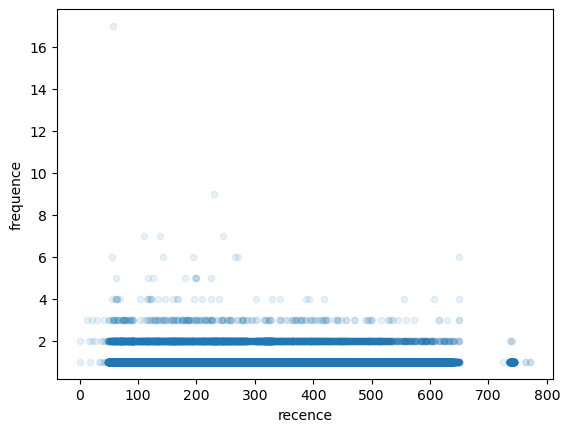

In [48]:
# Création du scatter plot
df.plot.scatter(x='recence', y='frequence', alpha=0.1)

# Affichage du graphique
plt.show()

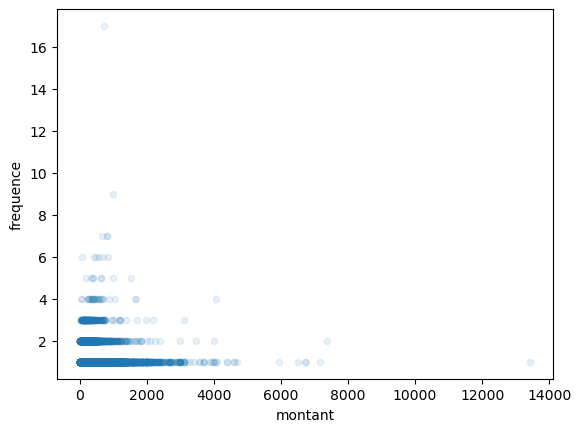

In [49]:
# Création du scatter plot
df.plot.scatter(x='montant', y='frequence', alpha=0.1)

# Affichage du graphique
plt.show()

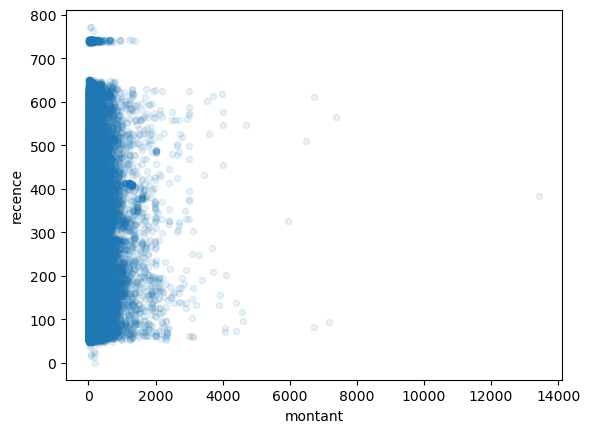

In [50]:
# Création du scatter plot
df.plot.scatter(x='montant', y='recence', alpha=0.1)

# Affichage du graphique
plt.show()

**Projection 3D des features RFM:**

C:\Users\admin\AppData\Local\Temp\ipykernel_5080\1466269423.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df['montant'], df['frequence'], df['recence'], cmap='viridis', marker='o', s=50, alpha=0.6)


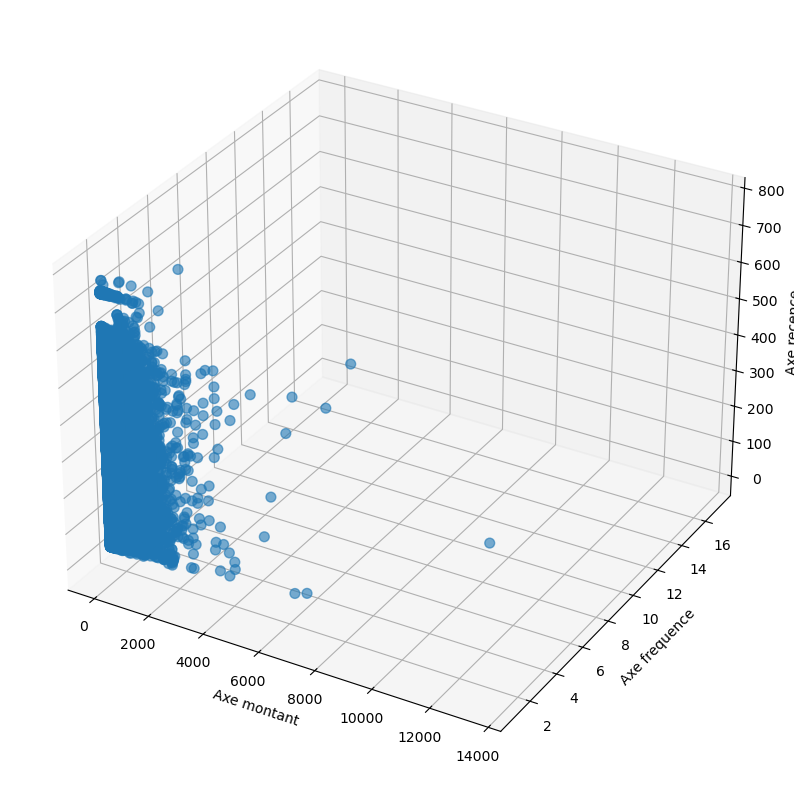

In [52]:
# Création de la figure 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Ajout des points au nuage
scatter = ax.scatter(df['montant'], df['frequence'], df['recence'], cmap='viridis', marker='o', s=50, alpha=0.6)

# Ajout des labels
ax.set_xlabel("Axe montant")
ax.set_ylabel("Axe frequence")
ax.set_zlabel("Axe recence")

# Afficher le graphique
plt.show()

#### 2.4 - normaliser les features RFM

Je vais utiliser ici QuantileTransformer pour normaliser des données qui seraient asymétriques (biaisées) :
- Redistribue les données pour qu'elles suivent une distribution cible, par exemple une distribution uniforme ou gaussienne.
- Insensible à l'échelle absolue des données, car il utilise les quantiles.

Comment fonctionne QuantileTransformer :
- Il classe les valeurs de la variable par leur rang (par exemple, en déciles ou percentiles).
- Chaque rang est ensuite transformé pour correspondre à une valeur dans la distribution cible. Par défaut, la distribution cible est uniforme [0,1], mais elle peut être définie comme gaussienne (normalisation).

**appliquons le quantileTranformer**

In [55]:
# Application de QuantileTransformer (par défaut, transforme en distribution uniforme)
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
df_transformed = quantile_transformer.fit_transform(df[['montant', 'recence', 'frequence']])

# Conversion en DataFrame
columns_to_transform = ['montant', 'recence', 'frequence']
df_transformed = pd.DataFrame(df_transformed, columns=columns_to_transform)

In [56]:
df_transformed.shape

(96096, 3)

In [57]:
df_transformed.describe()

,montant,recence,frequence
count,95420.000000,96096.000000,96096.000000
mean,-0.009137,-0.005261,-4.969655
std,1.002213,1.007897,1.281230
min,-5.199338,-5.199338,-5.199338
25%,-0.687939,-0.689529,-5.199338
50%,0.001255,-0.011291,-5.199338
75%,0.658043,0.689529,-5.199338
max,5.199338,5.199338,5.199338


In [58]:
# Remplacement des colonnes dans le DataFrame initial
df_transformed.index = df.index
df[columns_to_transform] = df_transformed
df.shape

(96096, 9)

In [59]:
df.describe()

,latitude,longitude,nb_jours_anciennete,recence,frequence,montant,nb_jours_entre_chaque_commande,score_moyen,nb_notes
count,95828.000000,95828.000000,96096.000000,96096.000000,96096.000000,95420.000000,96096.000000,96096.000000,96096.000000
mean,-21.116118,-46.115248,290.458552,-0.005261,-4.969655,-0.009137,269.908472,4.091807,1.032551
std,5.728565,4.103342,153.903666,1.007897,1.281230,1.002213,154.774479,1.338878,0.269283
min,-33.683447,-72.456263,0.000000,-5.199338,-5.199338,-5.199338,0.000000,1.000000,0.000000
25%,-23.577457,-48.051792,166.000000,-0.689529,-5.199338,-0.687939,143.756704,4.000000,1.000000
50%,-22.898404,-46.612833,272.000000,-0.011291,-5.199338,0.001255,245.729340,5.000000,1.000000
75%,-20.023054,-43.470899,400.000000,0.689529,-5.199338,0.658043,373.382616,5.000000,1.000000
max,45.065933,13.820214,772.000000,5.199338,5.199338,5.199338,772.718565,5.000000,17.000000


**Visualisons les nouvelles distributions**

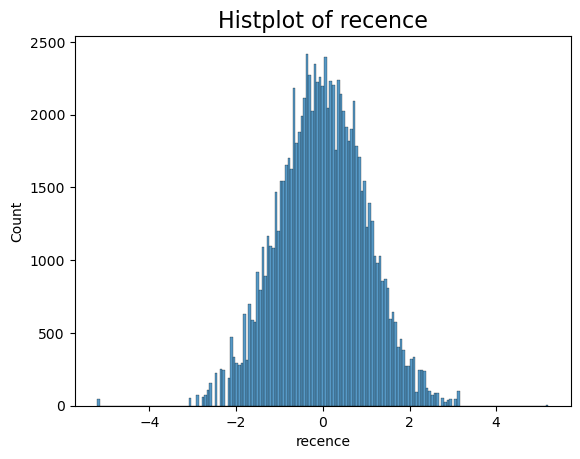

In [61]:
sns.histplot(data=df, x='recence')
plt.title('Histplot of recence', fontsize=16)
plt.show()

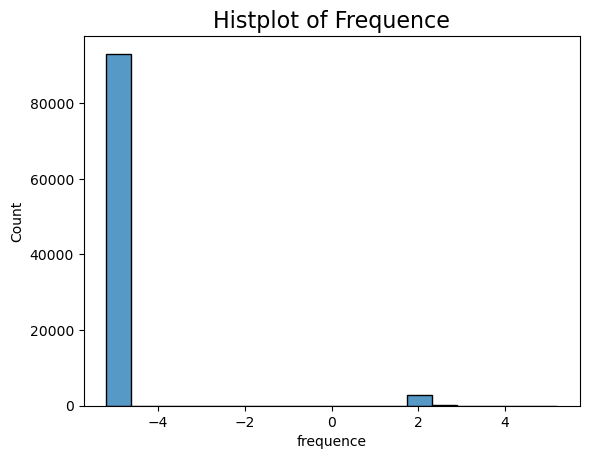

In [62]:
sns.histplot(data=df, x='frequence')
plt.title('Histplot of Frequence', fontsize=16)
plt.show()

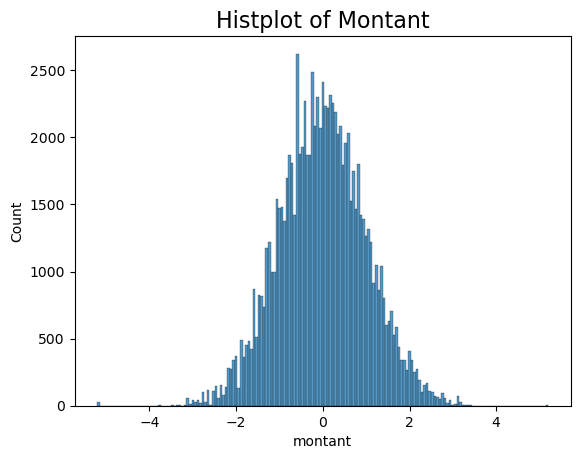

In [63]:
sns.histplot(data=df, x='montant')
plt.title('Histplot of Montant', fontsize=16)
plt.show()

**Projection 3D des features RFM:**

C:\Users\admin\AppData\Local\Temp\ipykernel_5080\1466269423.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df['montant'], df['frequence'], df['recence'], cmap='viridis', marker='o', s=50, alpha=0.6)


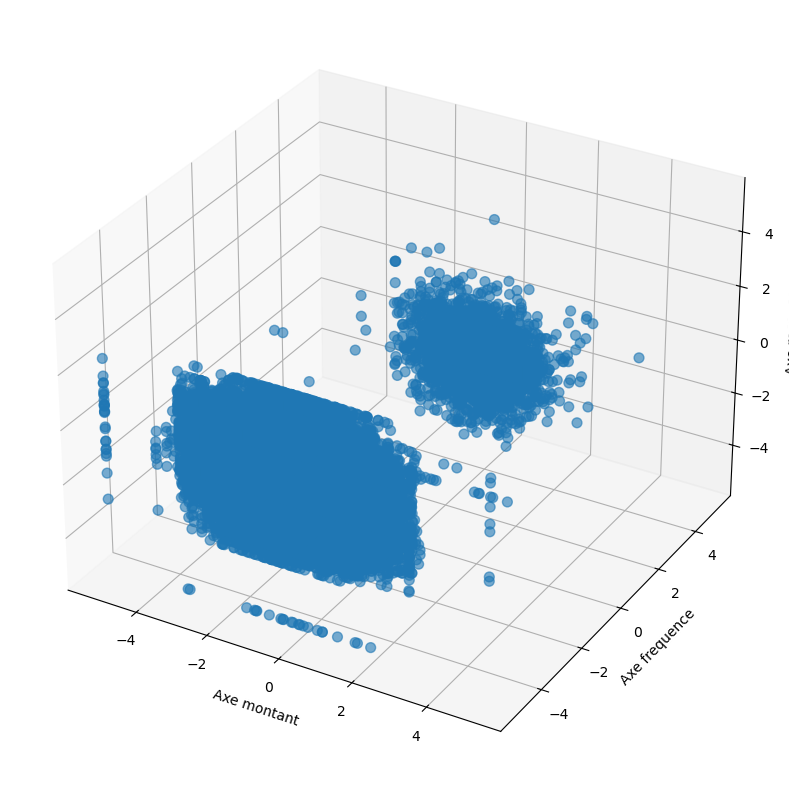

In [65]:
# Création de la figure 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Ajout des points au nuage
scatter = ax.scatter(df['montant'], df['frequence'], df['recence'], cmap='viridis', marker='o', s=50, alpha=0.6)

# Ajout des labels
ax.set_xlabel("Axe montant")
ax.set_ylabel("Axe frequence")
ax.set_zlabel("Axe recence")

# Afficher le graphique
plt.show()

#### 2.5 - export dataset vers CSV

In [67]:
df.to_csv('C:/Users/admin/Documents/Projets/Projet_5/data_projet/cleaned/data_olist_cleaned.csv', index=False)